<a href="https://colab.research.google.com/github/alecbidaran/Generative-deep-learning/blob/main/Covid19_lungs_CT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              227KB  2021-04-27 07:28:41           3760  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-02-17 16:10:44           2183  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Job Listing 2020                     42MB  2021-03-05 06:59:52            463  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:08:27           1384  
mathurinache/twitter-edge-nodes                             Twitter Edge Nod

In [ ]:
! kaggle datasets download -d andrewmvd/covid19-ct-scans

 97% 1.01G/1.03G [00:10<00:00, 60.2MB/s]
100% 1.03G/1.03G [00:10<00:00, 108MB/s] 


In [ ]:
!unzip covid19-ct-scans.zip

Archive:  covid19-ct-scans.zip
  inflating: ct_scans/coronacases_org_001.nii  
  inflating: ct_scans/coronacases_org_002.nii  
  inflating: ct_scans/coronacases_org_003.nii  
  inflating: ct_scans/coronacases_org_004.nii  
  inflating: ct_scans/coronacases_org_005.nii  
  inflating: ct_scans/coronacases_org_006.nii  
  inflating: ct_scans/coronacases_org_007.nii  
  inflating: ct_scans/coronacases_org_008.nii  
  inflating: ct_scans/coronacases_org_009.nii  
  inflating: ct_scans/coronacases_org_010.nii  
  inflating: ct_scans/radiopaedia_org_covid-19-pneumonia-10_85902_1-dcm.nii  
  inflating: ct_scans/radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm.nii  
  inflating: ct_scans/radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm.nii  
  inflating: ct_scans/radiopaedia_org_covid-19-pneumonia-27_86410_0-dcm.nii  
  inflating: ct_scans/radiopaedia_org_covid-19-pneumonia-29_86490_1-dcm.nii  
  inflating: ct_scans/radiopaedia_org_covid-19-pneumonia-29_86491_1-dcm.nii  
  inflating: ct_scans

In [ ]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

In [ ]:
!pip install nibabel

In [ ]:
from tensorflow.keras.losses import binary_crossentropy, mean_squared_error
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization, add, concatenate, Lambda, Flatten, Conv2DTranspose,DepthwiseConv2D
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.datasets import fashion_mnist
import tensorflow.keras as keras 
import tensorflow as tf
import numpy as np 
import cv2 
from imutils import paths
import os 
import pandas as pd 
import nibabel as nib
import matplotlib.pyplot as plt


In [ ]:
data=pd.read_csv("metadata.csv")
data.sample(5)

,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
14,../input/covid19-ct-scans/ct_scans/radiopaedia...,../input/covid19-ct-scans/lung_mask/radiopaedi...,../input/covid19-ct-scans/infection_mask/radio...,../input/covid19-ct-scans/lung_and_infection_m...
3,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
13,../input/covid19-ct-scans/ct_scans/radiopaedia...,../input/covid19-ct-scans/lung_mask/radiopaedi...,../input/covid19-ct-scans/infection_mask/radio...,../input/covid19-ct-scans/lung_and_infection_m...
0,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
2,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...


In [ ]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array)) #this data needs to rotate 90 degrees 
    return(array)

In [ ]:
CT_path="/content/input/covid19-ct-scans/ct_scans/"
Mask_path="/content/input/covid19-ct-scans/infection_mask/"
ct_scan_path=os.listdir(CT_path)
infection_mask=os.listdir(Mask_path)

In [ ]:
len(data)

20

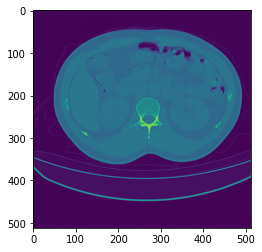

In [ ]:
sample_ct=read_nii(CT_path+ct_scan_path[1])
plt.imshow(sample_ct[...,0])

In [ ]:
CT = []
Mask = []
img_size = 128




for case in range(10): #Concat all cases to list
    ct = read_nii(CT_path+ct_scan_path[case])
    mask = read_nii(Mask_path+infection_mask[case])
    
    for imgsize in range(20):        
        ct_img = cv2.resize(ct[..., imgsize], dsize = (img_size, img_size),interpolation = cv2.INTER_AREA).astype('float64')
        mask_img = cv2.resize(mask[...,imgsize],dsize=(img_size, img_size),interpolation = cv2.INTER_AREA).astype('float64')
        CT.append(ct_img[..., np.newaxis])
        Mask.append(mask_img[..., np.newaxis])

In [ ]:
len(Mask)

200

In [ ]:
CT=np.array(CT)
Mask=np.array(Mask)

In [ ]:
mins = CT.min(axis=(1,2,3), keepdims=True)
maxs = CT.max(axis=(1,2,3), keepdims=True)
norm_data = (CT-mins)/(maxs-mins)

In [ ]:
from sklearn.model_selection import train_test_split
CT_train, CT_test, Mask_train, Mask_test = train_test_split(norm_data, Mask, test_size = 0.1)

In [ ]:
#@markdown ### 3.5. Define loss and model
# LOSS
def dice_coeff(y_true, y_pred):
    smooth =0.001
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss


#MODEL
def create_model(input_shape=(128,128, 1), init_nb=16, num_classes=1):
    
    inputs = Input(input_shape)
    
    down1 = Conv2D(init_nb, (3, 3), padding='same')(inputs)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1pool = Conv2D(init_nb, (3, 3), padding='same', strides=(2, 2))(down1)
    down1pool = BatchNormalization()(down1pool)
    down1pool = Activation('relu')(down1pool)
    
    down2 = Conv2D(init_nb * 2, (3, 3), padding='same')(down1pool)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2pool = Conv2D(init_nb * 2, (3, 3), padding='same', strides=(2, 2))(down2)
    down2pool = BatchNormalization()(down2pool)
    down2pool = Activation('relu')(down2pool)

    down3 = Conv2D(init_nb * 4, (3, 3), padding='same')(down2pool)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3pool = Conv2D(init_nb * 4, (3, 3), padding='same', strides=(2, 2))(down3)
    down3pool = BatchNormalization()(down3pool)
    down3pool = Activation('relu')(down3pool)
    
    # stacked dilated convolution
    dilate1 = Conv2D(init_nb * 8, (3, 3), padding='same', dilation_rate=1)(down3pool)
    dilate1 = BatchNormalization()(dilate1)
    dilate1 = Activation('relu')(dilate1)
    dilate2 = Conv2D(init_nb * 8, (3, 3), padding='same', dilation_rate=2)(dilate1)
    dilate2 = BatchNormalization()(dilate2)
    dilate2 = Activation('relu')(dilate2)
    dilate3 = Conv2D(init_nb * 8, (3, 3), padding='same', dilation_rate=4)(dilate2)
    dilate3 = BatchNormalization()(dilate3)
    dilate3 = Activation('relu')(dilate3)
    dilate4 = Conv2D(init_nb * 8, (3, 3), padding='same', dilation_rate=8)(dilate3)
    dilate4 = BatchNormalization()(dilate4)
    dilate4 = Activation('relu')(dilate4)
    
    dilate_all_added = add([dilate1, dilate2, dilate3, dilate4])
    
    up3 = Conv2DTranspose(init_nb * 4, (3, 3), padding='same', strides=(2, 2))(dilate_all_added)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = add([down3, up3])
    up3 = Conv2D(init_nb * 4, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    
    up2 = Conv2DTranspose(init_nb * 2, (3, 3), padding='same', strides=(2, 2))(up3)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = add([down2, up2])
    up2 = Conv2D(init_nb * 2, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    
    up1 = Conv2DTranspose(init_nb, (3, 3), padding='same', strides=(2, 2))(up2)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = add([down1, up1])
    up1 = Conv2D(init_nb, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    
    classify = Conv2D(num_classes, (1, 1), activation='sigmoid')(up1)

    model = Model(inputs=inputs, outputs=classify)
    return model

In [ ]:
disturbution=tf.distribute.experimental.CentralStorageStrategy()
lr=1e-4  
loss=bce_dice_loss
with disturbution.scope():

  model=create_model()
  model.compile(optimizer=Adam(lr), loss=loss, metrics=[dice_coeff])
  model.summary()


INFO:tensorflow:ParameterServerStrategy (CentralStorageStrategy if you are using a single machine) with compute_devices = ['/job:localhost/replica:0/task:0/device:GPU:0'], variable_device = '/job:localhost/replica:0/task:0/device:GPU:0'
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 128, 128, 16) 160         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_48 (BatchNo (None, 128, 128, 16) 64          conv2d_42[0][0]                  
_____________________________________________________

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=8,
                           verbose=1,
                           min_delta=1e-3),
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=4,
                               verbose=1,
                               min_delta=1e-3)]

In [ ]:
model.fit(CT_train,Mask_train,epochs=50,verbose=1,callbacks=callbacks,validation_split=0.1)

Epoch 1/50
6/6 [==============================] - 3s 547ms/step - loss: 1.2695 - dice_coeff: 0.0165 - val_loss: 1.5141 - val_dice_coeff: 0.0076
Epoch 2/50
6/6 [==============================] - 0s 70ms/step - loss: 1.2646 - dice_coeff: 0.0128 - val_loss: 1.5073 - val_dice_coeff: 0.0076
Epoch 3/50
6/6 [==============================] - 0s 70ms/step - loss: 1.2602 - dice_coeff: 0.0145 - val_loss: 1.4989 - val_dice_coeff: 0.0076
Epoch 4/50
6/6 [==============================] - 0s 70ms/step - loss: 1.2554 - dice_coeff: 0.0168 - val_loss: 1.4908 - val_dice_coeff: 0.0077
Epoch 5/50
6/6 [==============================] - 0s 69ms/step - loss: 1.2496 - dice_coeff: 0.0179 - val_loss: 1.4816 - val_dice_coeff: 0.0077
Epoch 6/50
6/6 [==============================] - 0s 70ms/step - loss: 1.2446 - dice_coeff: 0.0197 - val_loss: 1.4737 - val_dice_coeff: 0.0078
Epoch 7/50
6/6 [==============================] - 0s 70ms/step - loss: 1.2389 - dice_coeff: 0.0161 - val_loss: 1.4644 - val_dice_coeff: 0.007

In [ ]:
predict=model.predict(CT_test)

In [ ]:
import matplotlib.pyplot as plt 
import numpy as np 
import cv2 

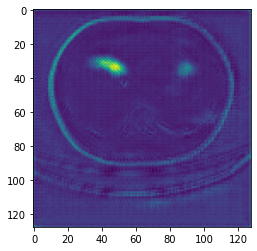

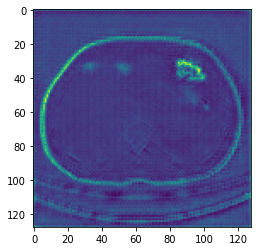

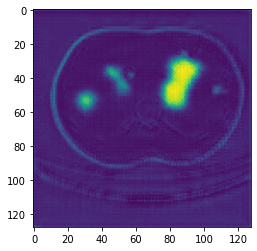

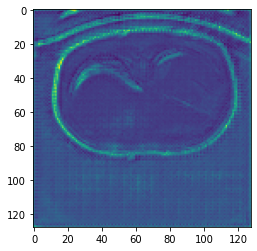

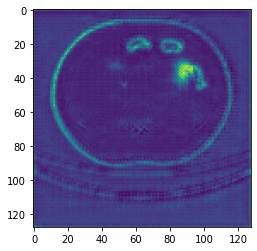

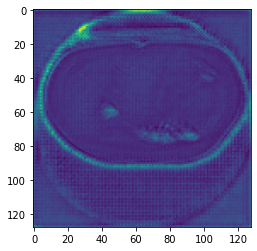

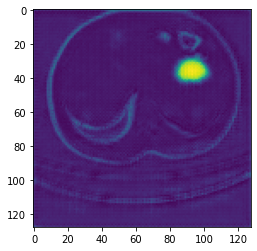

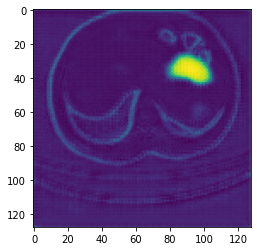

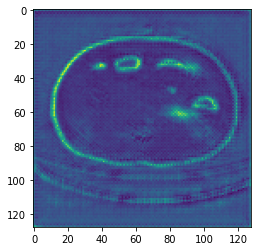

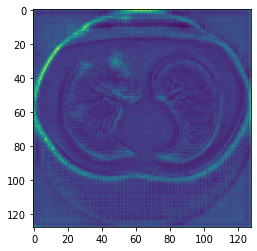

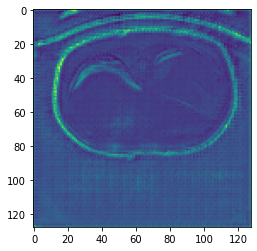

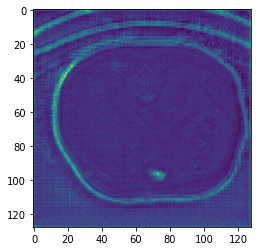

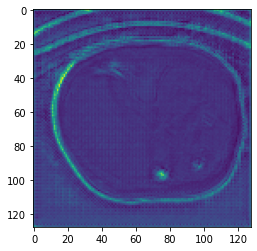

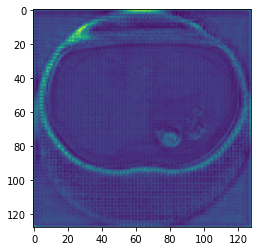

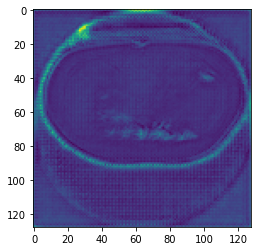

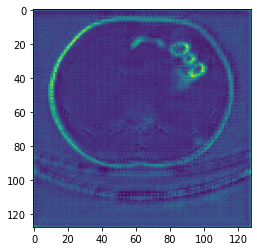

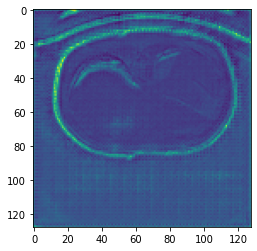

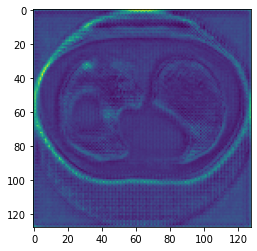

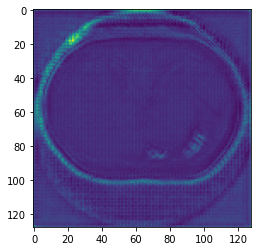

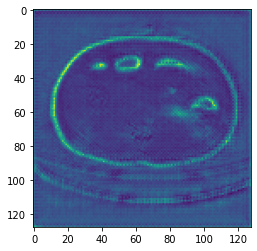

In [ ]:
for i in range(len(predict)):
  plt.figure()
  plt.imshow(np.squeeze(predict[i,:,:,:]))



In [ ]:
model.save("Covid_CT.h5")